# Control runs

In [1]:
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
from dask.distributed import Client

from modules import stats
importlib.reload(stats)

<module 'modules.stats' from '/srv/ccrc/AtmSS/z5310829/honours_project/modules/stats.py'>

In [2]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit='8GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42281,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:43741,Total threads: 1
Dashboard: http://127.0.0.1:35701/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:39673,


## Uncertainty estimation

### Data
- $N_x, N_z, \Gamma = 1024, 192, 8$
- $\Delta t = 0.0016$
- Simulation time 300 units
- Initial condition: interpolated from 256 x 128 after 1000 time unit spin-up
- Output frequency: 0.2 time units
- $\mathrm{Ra} = 10^9$
- $\mathrm{Pr} = 1$
- Hyperdiffusivity $\nu^* = 10^{-3}$

In [4]:
data = xr.open_mfdataset('../data/control/1024_192/*_s*.nc')
rayleigh = 1e9
prandtl = 1

### Nusselt number

In [5]:
nusselt = stats.nusselt_number(data, rayleigh, prandtl).compute()

[(-5.0, 5.0),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, '% change'),
 Text(0.5, 1.0, 'Percentage change in 100 time unit rolling mean')]

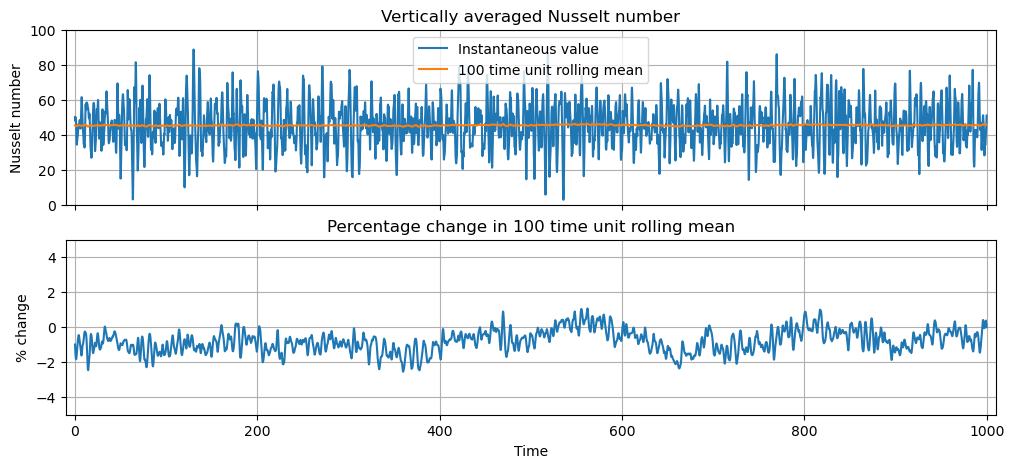

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

interval = (data.t[1] - data.t[0]).item()
window = round(100/interval) + 1
mean = nusselt.rolling(t=window, center=True, min_periods=window//2).mean()

axes[0].plot(nusselt.t, nusselt, label='Instantaneous value')
axes[0].plot(mean.t, mean, label='100 time unit rolling mean')
axes[0].grid()
axes[0].legend()
axes[0].set(
    ylim=(0, 100), xlim=(-10, 1010), ylabel='Nusselt number',
    title='Vertically averaged Nusselt number'    
)

axes[1].plot(mean.t, (mean/mean[~mean.isnull()].isel(t=-1) - 1)*1e2)
axes[1].grid()
axes[1].set(
    ylim=(-5, 5), xlabel='Time', ylabel=r'% change',
    title='Percentage change in 100 time unit rolling mean'
)

### RMS speed

In [7]:
rms_speed = stats.rms_speed(data).compute()

[Text(0, 0.5, '% change')]

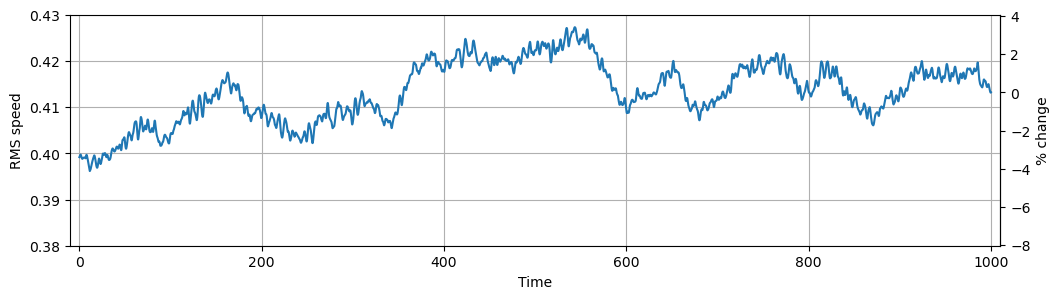

In [15]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(rms_speed.t, rms_speed)
ax.grid()
ax.set(ylim=(0.38, 0.43), xlim=(-10, 1010), ylabel='RMS speed', xlabel='Time')

ref = rms_speed.isel(t=-1).item()
sec_ax = ax.secondary_yaxis(
    'right',
    functions=(lambda x: (x/ref - 1)*1e2, lambda x: (x/1e2 + 1)*ref),
)
sec_ax.set(ylabel=r'% change')

### Kinetic energy dissipation rate

In [9]:
eps_k = stats.kinetic_dissipation(data, rayleigh, prandtl).compute()

[(-10.0, 5.0),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, '% change'),
 Text(0.5, 1.0, 'Percentage change in 100 time unit rolling mean')]

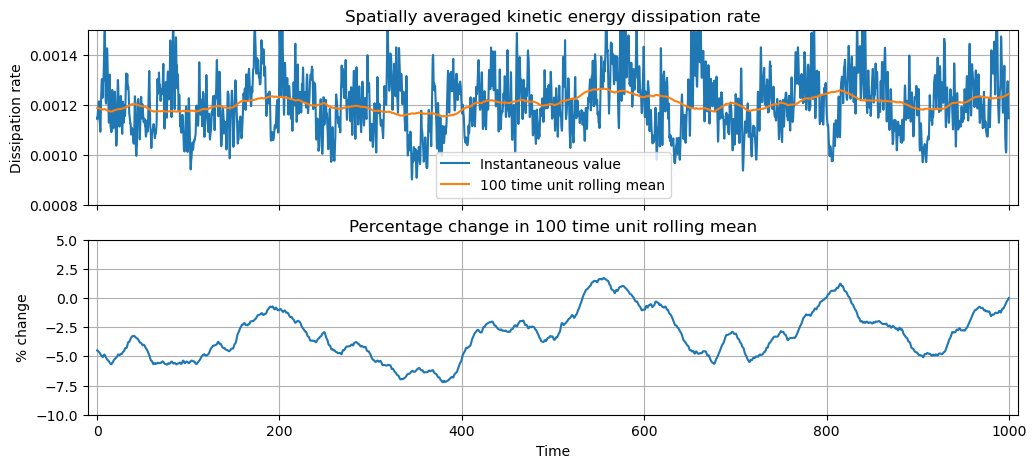

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

interval = (data.t[1] - data.t[0]).item()
window = round(100/interval) + 1
mean = eps_k.rolling(t=window, center=True, min_periods=window//2).mean()

axes[0].plot(eps_k.t, eps_k, label='Instantaneous value')
axes[0].plot(mean.t, mean, label='100 time unit rolling mean')
axes[0].grid()
axes[0].legend()
axes[0].set(
    ylim=(0.8e-3, 1.5e-3), xlim=(-10, 1010), ylabel='Dissipation rate',
    title='Spatially averaged kinetic energy dissipation rate'    
)

axes[1].plot(mean.t, (mean/mean[~mean.isnull()].isel(t=-1) - 1)*1e2)
axes[1].grid()
axes[1].set(
    ylim=(-10, 5), xlabel='Time', ylabel=r'% change',
    title='Percentage change in 100 time unit rolling mean'
)

### Thermal energy dissipation rate

In [11]:
eps_T = stats.thermal_dissipation(data, rayleigh, prandtl).compute()

[(-2.0, 2.0),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, '% change'),
 Text(0.5, 1.0, 'Percentage change in 100 time unit rolling mean')]

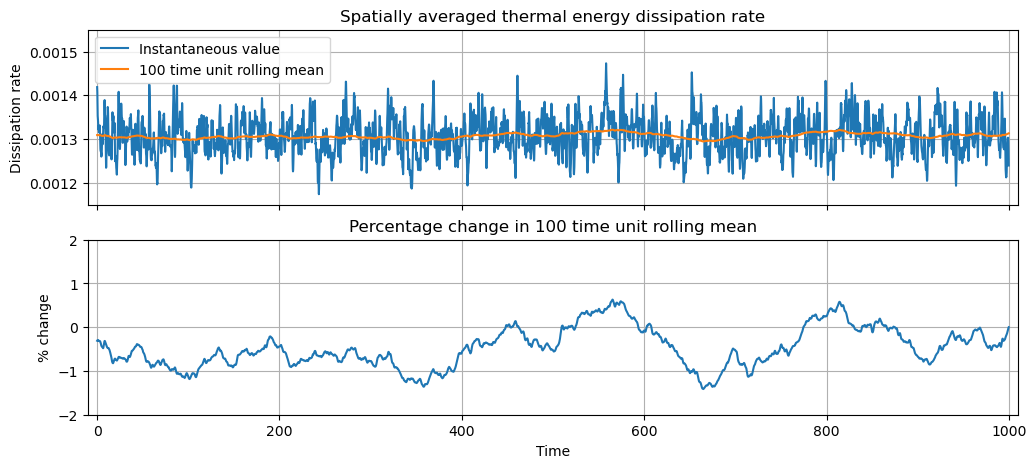

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

interval = (data.t[1] - data.t[0]).item()
window = round(100/interval) + 1
mean = eps_T.rolling(t=window, center=True, min_periods=window//2).mean()

axes[0].plot(eps_T.t, eps_T, label='Instantaneous value')
axes[0].plot(mean.t, mean, label='100 time unit rolling mean')
axes[0].grid()
axes[0].legend(loc='upper left')
axes[0].set(
    ylim=(1.15e-3, 1.55e-3), xlim=(-10, 1010), ylabel='Dissipation rate',
    title='Spatially averaged thermal energy dissipation rate'    
)

axes[1].plot(mean.t, (mean/mean[~mean.isnull()].isel(t=-1) - 1)*1e2)
axes[1].grid()
axes[1].set(
    ylim=(-2, 2), xlabel='Time', ylabel=r'% change',
    title='Percentage change in 100 time unit rolling mean'
)

### Estimating required simulation time

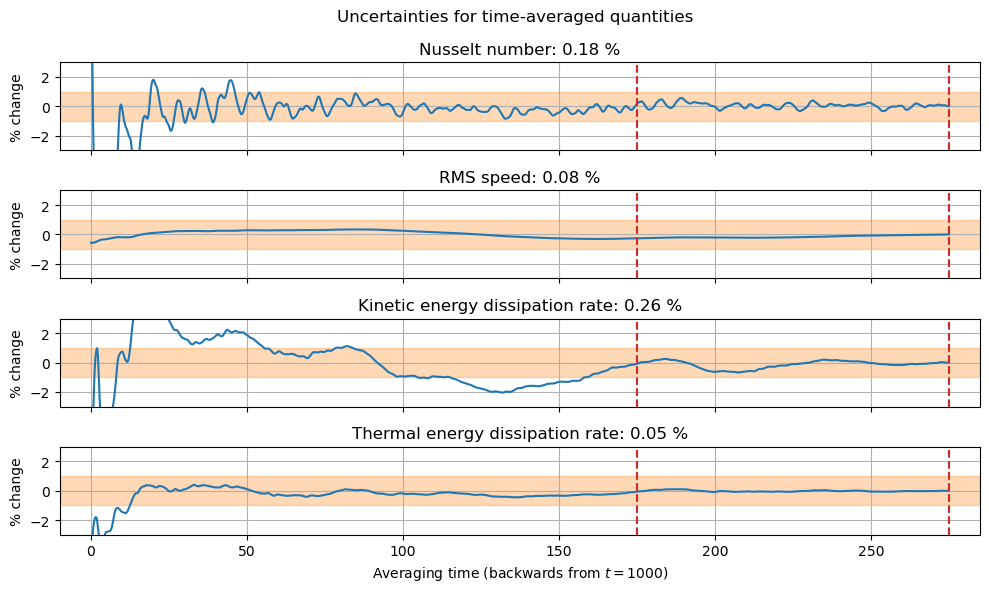

In [13]:
t_max = 275.
t_delta = t_max - 100
metrics = {
    'Nusselt number': nusselt,
    'RMS speed': rms_speed,
    'Kinetic energy dissipation rate': eps_k,
    'Thermal energy dissipation rate': eps_T,
}
fig, axes = plt.subplots(
    len(metrics), 1, figsize=(10, 1.5*len(metrics)), sharex=True)

for i, m in enumerate(metrics):
    mean = stats.reverse_running_mean(metrics[m], 't')
    mean = mean[mean.t <= t_max]
    delta = mean[mean.t >= t_delta].std()
    axes[i].plot(mean.t, (mean/mean.isel(t=-1) - 1)*1e2)
    axes[i].fill_between(
        axes[i].get_xlim(), -1, 1, color='tab:orange', alpha=0.3)
    axes[i].grid()
    axes[i].set(
        ylabel=r'% change', title=f'{m}: {delta/mean.isel(t=-1)*1e2:.2f} %',
        ylim=(-3, 3), xlim=(-10, t_max + 10)
    )
    axes[i].vlines(
        [t_delta, t_max], *axes[i].get_ylim(),
        linestyle='--', color='tab:red')

axes[-1].set(xlabel=f'Averaging time (backwards from $t={data.t.max():.0f}$)')
fig.suptitle('Uncertainties for time-averaged quantities', x=0.52)
fig.tight_layout()

## Model runs

In [5]:
nx0 = 1024
nz0 = 192
dt0 = 1.6e-3
dt_save = 0.2
max_writes0 = 200
aspect = 8

nx = np.array([128, 256, 384, 512, 768, 1024, 1024, 256, 256, 256])
nz = np.array([192, 192, 192, 192, 192, 192, 128, 108, 128, 160])
dt = (nx0/aspect + nz0)/(nx/aspect + nz)*dt0
dt = np.round(dt, 5)
save = np.int32(np.round(dt_save/dt, 0))
max_writes = np.int32(max_writes0/((nx/nx0)*(nz/nz0)))//100*100

print('(N_x, N_z, dt):')
with np.printoptions(suppress=True):
    print(np.array(list(zip(nx.flat, nz.flat, dt.flat))))

(N_x, N_z, dt):
[[ 128.       192.         0.00246]
 [ 256.       192.         0.00229]
 [ 384.       192.         0.00213]
 [ 512.       192.         0.002  ]
 [ 768.       192.         0.00178]
 [1024.       192.         0.0016 ]
 [1024.       128.         0.002  ]
 [ 256.       108.         0.00366]
 [ 256.       128.         0.0032 ]
 [ 256.       160.         0.00267]]


In [3]:
rayleigh = 1e9
prandtl = 1

data = {}
nx_list = [128, 256, 384, 512, 768, 1024, 256, 256, 256]
nz_list = [192, 192, 192, 192, 192, 192, 160, 128, 108]
for nx, nz in zip(nx_list, nz_list):
    name = f'{nx}_{nz}/*_s*.nc'
    ds = xr.open_mfdataset(
        f'../data/control/{name}', chunks={'t': 'auto', 'x': -1, 'z': -1})
    data[(nx, nz)] = ds.isel(t=((ds.t >= 25) & (ds.t <= 300)))

### Nusselt number

In [4]:
nusselt = {}
for nx, nz in data.keys():
    nu = stats.nusselt_number(data[(nx, nz)], rayleigh, prandtl)
    nusselt[(nx, nz)] = nu.compute()

In [35]:
mean_nusselt = xr.DataArray(
    coords={'nx': np.unique(nx_list), 'nz': np.unique(nz_list)},
    dims=['nx', 'nz'],
)
delta_nusselt = mean_nusselt.copy()
std_nusselt = mean_nusselt.copy()
delta_std_nusselt = mean_nusselt.copy()
for nx, nz in data.keys():
    mean_nusselt.loc[{'nx': nx, 'nz': nz}] = nusselt[nx, nz].mean('t')
    running_mean = stats.reverse_running_mean(nusselt[nx, nz], 't')
    delta = running_mean[running_mean.t.max() - running_mean.t <= 100].std()
    delta_nusselt.loc[{'nx': nx, 'nz': nz}] = delta

    std_nusselt.loc[{'nx': nx, 'nz': nz}] = nusselt[nx, nz].std('t')
    running_var = stats.reverse_running_mean(
        (nusselt[nx, nz] - mean_nusselt.sel(nx=nx, nz=nz))**2, 't')
    running_std = np.sqrt(running_var)
    delta_std = running_std[running_std.t.max() - running_std.t <= 100].std()
    delta_std_nusselt.loc[{'nx': nx, 'nz': nz}] = delta_std

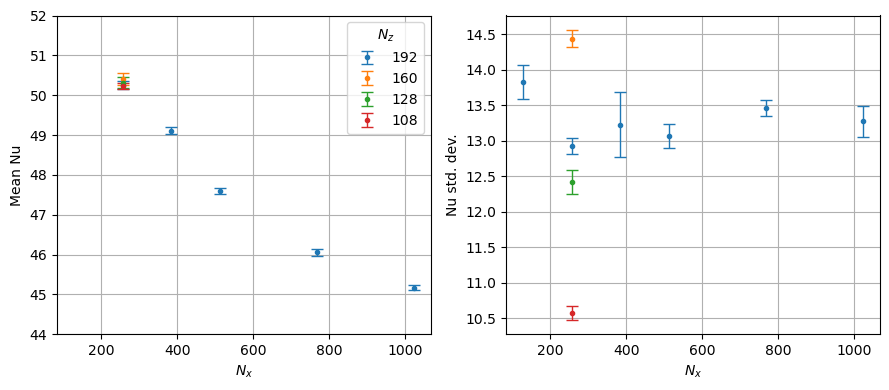

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for nz in [192, 160, 128, 108]:
    axes[0].errorbar(
        mean_nusselt.nx, mean_nusselt.sel(nz=nz).data,
        yerr=delta_nusselt.sel(nz=nz).data, capsize=4, elinewidth=1,
        marker='.', linestyle='', label=str(nz))
    axes[1].errorbar(
        std_nusselt.nx, std_nusselt.sel(nz=nz).data,
        yerr=delta_std_nusselt.sel(nz=nz).data, capsize=4, elinewidth=1,
        marker='.', linestyle='')
axes[0].grid()
axes[1].grid()
axes[0].set(
    xlabel='$N_x$', ylabel='Mean Nu', ylim=(44, 52)
)
axes[1].set(xlabel='$N_x$', ylabel='Nu std. dev.')
axes[0].legend(title='$N_z$')
fig.tight_layout()

### RMS speed

In [15]:
rms_speed = {}
for nx, nz in data.keys():
    rms_speed[(nx, nz)] = stats.rms_speed(data[(nx, nz)]).compute()

In [41]:
mean_rms_speed = xr.DataArray(
    coords={'nx': np.unique(nx_list), 'nz': np.unique(nz_list)},
    dims=['nx', 'nz'],
)
delta_rms_speed = mean_rms_speed.copy()
std_rms_speed = mean_rms_speed.copy()
delta_std_rms_speed = mean_rms_speed.copy()
for nx, nz in data.keys():
    mean_rms_speed.loc[{'nx': nx, 'nz': nz}] = rms_speed[nx, nz].mean('t')
    running_mean = stats.reverse_running_mean(rms_speed[nx, nz], 't')
    delta = running_mean[running_mean.t.max() - running_mean.t <= 100].std()
    delta_rms_speed.loc[{'nx': nx, 'nz': nz}] = delta

    std_rms_speed.loc[{'nx': nx, 'nz': nz}] = rms_speed[nx, nz].std('t')
    running_var = stats.reverse_running_mean(
        (rms_speed[nx, nz] - mean_rms_speed.sel(nx=nx, nz=nz))**2, 't')
    running_std = np.sqrt(running_var)
    delta_std = running_std[running_std.t.max() - running_std.t <= 100].std()
    delta_std_rms_speed.loc[{'nx': nx, 'nz': nz}] = delta_std

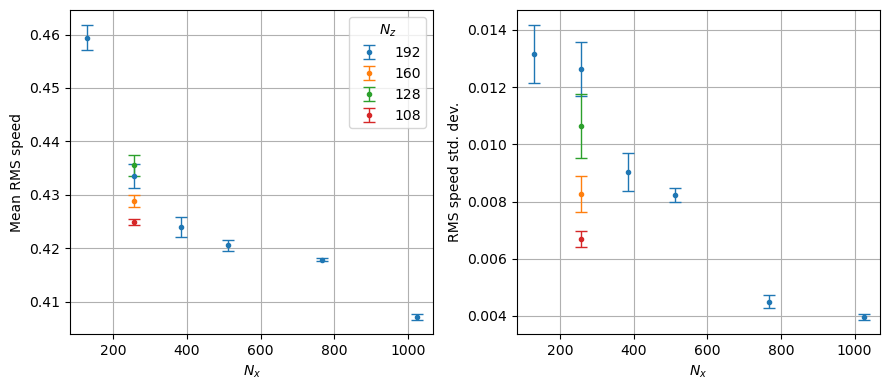

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for nz in [192, 160, 128, 108]:
    axes[0].errorbar(
        mean_rms_speed.nx, mean_rms_speed.sel(nz=nz).data,
        yerr=delta_rms_speed.sel(nz=nz).data, capsize=4, elinewidth=1,
        marker='.', linestyle='', label=str(nz))
    axes[1].errorbar(
        std_rms_speed.nx, std_rms_speed.sel(nz=nz).data,
        yerr=delta_std_rms_speed.sel(nz=nz).data, capsize=4, elinewidth=1,
        marker='.', linestyle='')
axes[0].grid()
axes[1].grid()
axes[0].set(
    xlabel='$N_x$', ylabel='Mean RMS speed'
)
axes[1].set(xlabel='$N_x$', ylabel='RMS speed std. dev.')
axes[0].legend(title='$N_z$')
fig.tight_layout()

### Kinetic dissipation rate

In [22]:
eps_k = {}
for nx, nz in data.keys():
    eps = stats.kinetic_dissipation(data[(nx, nz)], rayleigh, prandtl)
    eps_k[(nx, nz)] = eps.compute()

In [47]:
mean_eps_k = xr.DataArray(
    coords={'nx': np.unique(nx_list), 'nz': np.unique(nz_list)},
    dims=['nx', 'nz'],
)
delta_eps_k = mean_eps_k.copy()
std_eps_k = mean_eps_k.copy()
delta_std_eps_k = mean_eps_k.copy()
for nx, nz in data.keys():
    mean_eps_k.loc[{'nx': nx, 'nz': nz}] = eps_k[nx, nz].mean('t')
    running_mean = stats.reverse_running_mean(eps_k[nx, nz], 't')
    delta = running_mean[running_mean.t.max() - running_mean.t <= 100].std()
    delta_eps_k.loc[{'nx': nx, 'nz': nz}] = delta

    std_eps_k.loc[{'nx': nx, 'nz': nz}] = eps_k[nx, nz].std('t')
    running_var = stats.reverse_running_mean(
        (eps_k[nx, nz] - mean_eps_k.sel(nx=nx, nz=nz))**2, 't')
    running_std = np.sqrt(running_var)
    delta_std = running_std[running_std.t.max() - running_std.t <= 100].std()
    delta_std_eps_k.loc[{'nx': nx, 'nz': nz}] = delta_std

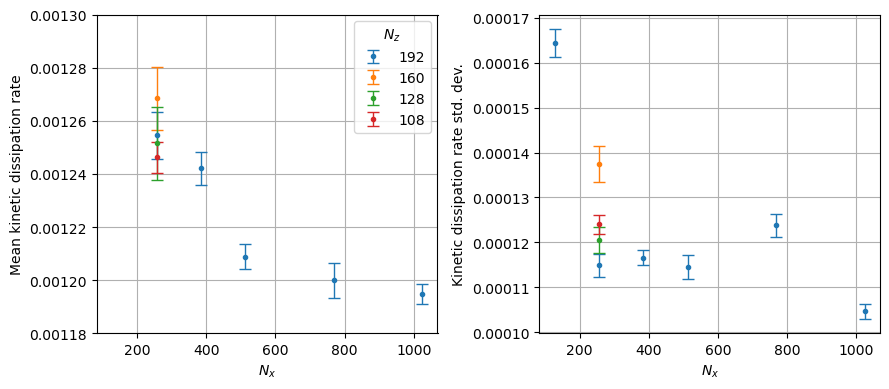

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for nz in [192, 160, 128, 108]:
    axes[0].errorbar(
        mean_eps_k.nx, mean_eps_k.sel(nz=nz).data,
        yerr=delta_eps_k.sel(nz=nz).data, capsize=4, elinewidth=1,
        marker='.', linestyle='', label=str(nz))
    axes[1].errorbar(
        std_eps_k.nx, std_eps_k.sel(nz=nz).data,
        yerr=delta_std_eps_k.sel(nz=nz).data, capsize=4, elinewidth=1,
        marker='.', linestyle='')
axes[0].grid()
axes[1].grid()
axes[0].set(
    xlabel='$N_x$', ylabel='Mean kinetic dissipation rate',
    ylim=(1.18e-3, 1.3e-3)
)
axes[1].set(xlabel='$N_x$', ylabel='Kinetic dissipation rate std. dev.')
axes[0].legend(title='$N_z$')
fig.tight_layout()

### Thermal dissipation rate

In [27]:
eps_T = {}
for nx, nz in data.keys():
    eps = stats.thermal_dissipation(data[(nx, nz)], rayleigh, prandtl)
    eps_T[(nx, nz)] = eps.compute()

In [50]:
mean_eps_T = xr.DataArray(
    coords={'nx': np.unique(nx_list), 'nz': np.unique(nz_list)},
    dims=['nx', 'nz'],
)
delta_eps_T = mean_eps_T.copy()
std_eps_T = mean_eps_T.copy()
delta_std_eps_T = mean_eps_T.copy()
for nx, nz in data.keys():
    mean_eps_T.loc[{'nx': nx, 'nz': nz}] = eps_T[nx, nz].mean('t')
    running_mean = stats.reverse_running_mean(eps_T[nx, nz], 't')
    delta = running_mean[running_mean.t.max() - running_mean.t <= 100].std()
    delta_eps_T.loc[{'nx': nx, 'nz': nz}] = delta

    std_eps_T.loc[{'nx': nx, 'nz': nz}] = eps_T[nx, nz].std('t')
    running_var = stats.reverse_running_mean(
        (eps_T[nx, nz] - mean_eps_T.sel(nx=nx, nz=nz))**2, 't')
    running_std = np.sqrt(running_var)
    delta_std = running_std[running_std.t.max() - running_std.t <= 100].std()
    delta_std_eps_T.loc[{'nx': nx, 'nz': nz}] = delta_std

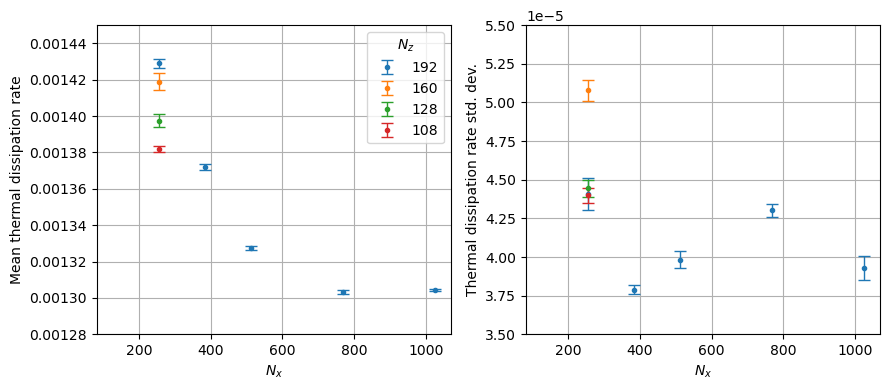

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for nz in [192, 160, 128, 108]:
    axes[0].errorbar(
        mean_eps_T.nx, mean_eps_T.sel(nz=nz).data,
        yerr=delta_eps_T.sel(nz=nz).data, capsize=4, elinewidth=1,
        marker='.', linestyle='', label=str(nz))
    axes[1].errorbar(
        std_eps_T.nx, std_eps_T.sel(nz=nz).data,
        yerr=delta_std_eps_T.sel(nz=nz).data, capsize=4, elinewidth=1,
        marker='.', linestyle='')
axes[0].grid()
axes[1].grid()
axes[0].set(
    xlabel='$N_x$', ylabel='Mean thermal dissipation rate',
    ylim=(1.28e-3, 1.45e-3)
)
axes[1].set(
    xlabel='$N_x$', ylabel='Thermal dissipation rate std. dev.',
    ylim=(3.5e-5, 5.5e-5)
)
axes[0].legend(title='$N_z$')
fig.tight_layout()

## Conclusions:
- Systematic overestimation of mean values for all 4 quantities as a result of insufficient horizontal resolution
- Either no discernible effect of vertical under-resolution, or an opposing under-estimation (not desirable as it masks the effect of horizontal resolution)
- There is only evidence of a resolution effect on variance for the RMS speed

## Next steps
- Check power spectra of variables: slow oscillations
- Determine data logging frequency for fitting step using autocorrelation
- Obtain fine resolution fitting dataset at reduced logging frequency starting from t_spinup + T
- Start diagnosing unresolved tendencies

In [20]:
client.close()